# グラフで2バイト文字を使うためのライブラリのインストール

In [1]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 86.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=141f7f46dcefc9fa34d3f13d5804b186d7829637862d6d07b7ff9c39f9656f51
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


# 乱数シードの固定

In [2]:
import random
import numpy as np
import os

np.random.seed(0)
random.seed(0)
os.environ["PYTHONHASHSEED"] = str(0)

# 関数 save_fig：図の保存用

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def save_fig(plt, file_prefix):
    if file_prefix == '':
        return

    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches='tight', pad_inches = 0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches='tight', pad_inches = 0.2)

# 関数 show_prediction：予測結果の可視化

In [4]:
def show_prediction(x, y_true, y_pred, ids, dataset='mnist', labels=None, file_prefix=''):
    '''認識結果を可視化する。
    Args:
        x (ndarray): 画像。形状は(B, N)。Bは画像枚数、Nは1枚の画像の画素数
        y_true (ndarray): 正解クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        y_pred (ndarray): 予測クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        ids (ndarray): 表示する画像のインデックスを格納した配列
        dataset (str): データセット名
        labels (list): クラスラベル名が格納されたリスト
        file_prefix (str): 可視化結果を保存する際のファイル名接頭辞
    '''

    def _mnist():
        """MNIST用可視化関数"""
        img = x[ids].reshape((len(ids), 28, 28))

        labels = y_true[ids]
        preds = y_pred[ids]

        # AIが認識した結果を画像と一緒に提示する
        plt.figure(2, figsize=(12, 8))
        plt.gray()
        for i in range(len(ids)):
            plt.subplot(8, 12, i + 1)
            plt.pcolor(img[i])
            plt.text(22, 25.5, "%d" % preds[i], fontsize=12, color='yellow')
            if preds[i] != labels[i]:
                plt.plot([0, 27], [1, 1], color='red', linewidth=5)

            plt.xlim(0, 27)
            plt.ylim(27, 0)
            plt.xticks([], '')
            plt.yticks([], '')

        plt.tight_layout()
        save_fig(plt, file_prefix=file_prefix)
        plt.show()

    def _cifar10():
        """CIFAR-10用可視化関数"""
        img = x[ids].reshape((len(ids), 32, 32, 3))

        trues = y_true[ids]
        preds = y_pred[ids]

        # AIが認識した結果を画像と一緒に提示する
        plt.figure(figsize=(24, 16))
        for i in range(len(ids)):
            plt.subplot(8, 12, i + 1)
            plt.imshow(img[i])

            p = preds[i]
            t = trues[i]
            if p != t:
                plt.title(f'{labels[t]}({labels[p]})', color='red', fontsize=12)
            else:
                plt.title(f'{labels[t]}', fontsize=12)

            plt.axis('off')

        plt.tight_layout()
        save_fig(plt, file_prefix=file_prefix)
        plt.show()

    if dataset == 'mnist':
        _mnist()
    else:
        _cifar10()

# 関数 evaluate：性能評価関数

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

def evalulate(x, y_true, y_pred, file_prefix=''):
    """予測結果に対する性能評価を行う。正解率、精度、再現率の計算。混同行列をヒートマップとして可視化。
    Args:
        x (ndarray): 画像。形状は(B, N)。Bは画像枚数、Nは1枚の画像の画素数
        y_true (ndarray): 正解クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        y_pred (ndarray): 予測クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        file_prefix (str): 可視化結果を保存する際のファイル名接頭辞
    """
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    print('正解率')
    print(f' {accuracy:.2f}')

    class_labels = []

    num_classes = np.max(y_true) + 1
    for i in range(num_classes):
        class_labels.append(f'{i:4d}')

    precision_str = []
    recall_str = []
    for i in range(num_classes):
        precision_str.append(f'{precision[i]:.2f}')
        recall_str.append(f'{recall[i]:.2f}')

    print('精度')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(precision_str))

    print('再現率')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(recall_str))

    plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=True, fmt='3d', square=True, cmap='hot')
    plt.tight_layout()
    save_fig(plt, file_prefix=file_prefix)
    plt.show()

# 関数 show_history：学習過程の可視化

In [8]:
def show_history(history, file_prefix=''):
    """学習過程（損失と正解率）を可視化する
    Args:
        history (tf.keras.callbacks.History): 損失やモニターする指標を格納したオブジェクト
    """
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(wspace=0.2)

    # 学習曲線の表示
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'black', label='Training')
    plt.plot(history.history['val_loss'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
    plt.title('損失', fontsize=16)
    plt.ylim(0, )
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

    # 正解率表示
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'black', label='Training')
    plt.plot(history.history['val_accuracy'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
    plt.title('正解率', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 1.2)
    plt.grid(True)

    save_fig(plt, file_prefix)

    plt.show()

# 関数 load_mnist：教師データを準備する関数を実装

In [9]:
# MNISTデータの訓練データとテストデータを使いやすいようにする
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

def load_mnist():
    """手書き数字データセットMNISTを教師データとして用意する。
    Returns:
        x_train (ndarray): 訓練データの画像配列。形状(60000, 784)
        y_train (ndarray): 訓練データのクラスラベル。one-hotベクトル化済み。形状(60000, 10)
        x_test (ndarray): テストデータの画像配列。形状(10000, 784)
        y_test (ndarray): テストデータのクラスラベル。one-hotベクトル化済み。形状(10000, 10)
        ny (int): 画像の縦方向画素数
        nx (int): 画像の横方向画素数
        num_classes (int): クラス数
    """
    # MNISTデータセットをTensorFlowのサイトからロード
    # (訓練データ画像, 訓練データ・クラスラベル), (テストデータ画像, テストデータ・クラスラベル)
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # 訓練データの準備
    print('訓練データ')
    print('画像枚数:', len(x_train))

    # 先頭の画像を取り出して、形状を取得
    ny, nx = x_train[0].shape
    print('画像の縦方向画素数:', ny)
    print('画像の横方向画素数:', nx)

    # 訓練データ数 60000。1つの画像は 28 x 28 = 784画素
    # 0から59999の各行には1個の画像が格納されている。
    # 全結合層へ入力するため、各画像をny * nx個の成分を持つ1次元配列へ変換。
    x_train = x_train.reshape(-1, ny * nx)
    x_train = x_train.astype('float32')   # 要素値の型をfloat32へ変更
    # 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
    x_train = x_train / 255

    # クラス数。0から9の数字なので10クラス
    num_classes = np.max(y_train) + 1
    print('クラス数:', num_classes)

    # クラスラベルをone-hotベクトル化
    y_train = to_categorical(y_train, num_classes)
    print('クラスラベルの形状:', y_train.shape)

    # テストデータの準備。テストデータ数 10000
    print('\nテストデータ')
    print('画像枚数:', len(x_test))

    # 訓練データと同様に1次元配列へ変換
    x_test = x_test.reshape(-1, ny * nx)
    x_test = x_test.astype('float32')  # 要素値の型をfloat32へ変更
    # 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
    x_test = x_test / 255

    # クラスラベルをone-hotベクトル化
    y_test = to_categorical(y_test, num_classes)

    return x_train, y_train, x_test, y_test, ny, nx, num_classes

# 実習9.1：MNIST分類用に10層の中間層が活性化関数ReLUを持つモデルの定義

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 教師データを再生成
x_train, y_train, x_test, y_test, nx, ny, num_classes = load_mnist()

# ネットワークのパラメータ（重みとバイアス）を初期化する際の乱数シードを固定
tf.random.set_seed(0)

n_hidden=10 # 中間層数

# ネットワークモデルを生成。層（レイヤー）の容器と考える。
model1=Sequential()

# 最初の中間層を追加
model1.add(Dense(input_dim=ny*nx,   # 入力層のニューロン数
                 units=10,          # 中間層のニューロン数
                 activation='relu', # 中間層の活性化関数ReLU
                 name='hidden1'))   # 中間層の名前
# 2から9番目の中間層を追加
for i in range(2,n_hidden+1):
    model1.add(Dense(units=10,
                     activation='relu',
                     name=f'hidden{i}'))

# 出力層を追加
model1.add(Dense(units=10,
                 activation='softmax',
                 name='output'))

model1.compile(optimizer='SGD',                 # パラメータの最適化手法にAdamを指定
               loss='categorical_crossentropy', # 損失関数
               metrics=['accuracy'])            # 損失の他にモニターする指標として正解率を指定

# モデルの要約情報を表示
model1.summary()

11490434/11490434 [==============================] - 2s 0us/step
訓練データ
画像枚数: 60000
画像の縦方向画素数: 28
画像の横方向画素数: 28
クラス数: 10
クラスラベルの形状: (60000, 10)

テストデータ
画像枚数: 10000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 10)                7850      
                                                                 
 hidden2 (Dense)             (None, 10)                110       
                                                                 
 hidden3 (Dense)             (None, 10)                110       
                                                                 
 hidden4 (Dense)             (None, 10)                110       
                                                                 
 hidden5 (Dense)             (None, 10)                110       
                                                                 
 hidden6 (Dense)         

# 実習9.2：model1の学習

In [11]:
# 学習開始。終了後、学習の履歴がhistory1に代入される
history1=model1.fit(x_train, # 訓練データ：入力画像
                    y_train, # 訓練データ：クラスラベル
                    epochs=500, # エポック数
                    batch_size=1000, # バッチサイズ
                    shuffle=True,    # 学習時にデータの並びをシャッフル
                    validation_data=(x_test,y_test)) # 学習過程での汎化能力の推定のためテストデータを指定

Epoch 1/500
60/60 [==============================] - 7s 13ms/step - loss: 2.3022 - accuracy: 0.1151 - val_loss: 2.3021 - val_accuracy: 0.1135
Epoch 2/500
60/60 [==============================] - 0s 6ms/step - loss: 2.3019 - accuracy: 0.1124 - val_loss: 2.3017 - val_accuracy: 0.1135
Epoch 3/500
60/60 [==============================] - 0s 6ms/step - loss: 2.3013 - accuracy: 0.1124 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 4/500
60/60 [==============================] - 0s 7ms/step - loss: 2.3008 - accuracy: 0.1124 - val_loss: 2.3006 - val_accuracy: 0.1135
Epoch 5/500
60/60 [==============================] - 0s 7ms/step - loss: 2.3003 - accuracy: 0.1124 - val_loss: 2.3002 - val_accuracy: 0.1135
Epoch 6/500
60/60 [==============================] - 0s 6ms/step - loss: 2.2998 - accuracy: 0.1124 - val_loss: 2.2997 - val_accuracy: 0.1135
Epoch 7/500
60/60 [==============================] - 0s 6ms/step - loss: 2.2992 - accuracy: 0.1124 - val_loss: 2.2989 - val_accuracy: 0.1135
Epoch 8/500


# 実習9.3：モデル1の学習の履歴と汎化能力の推定

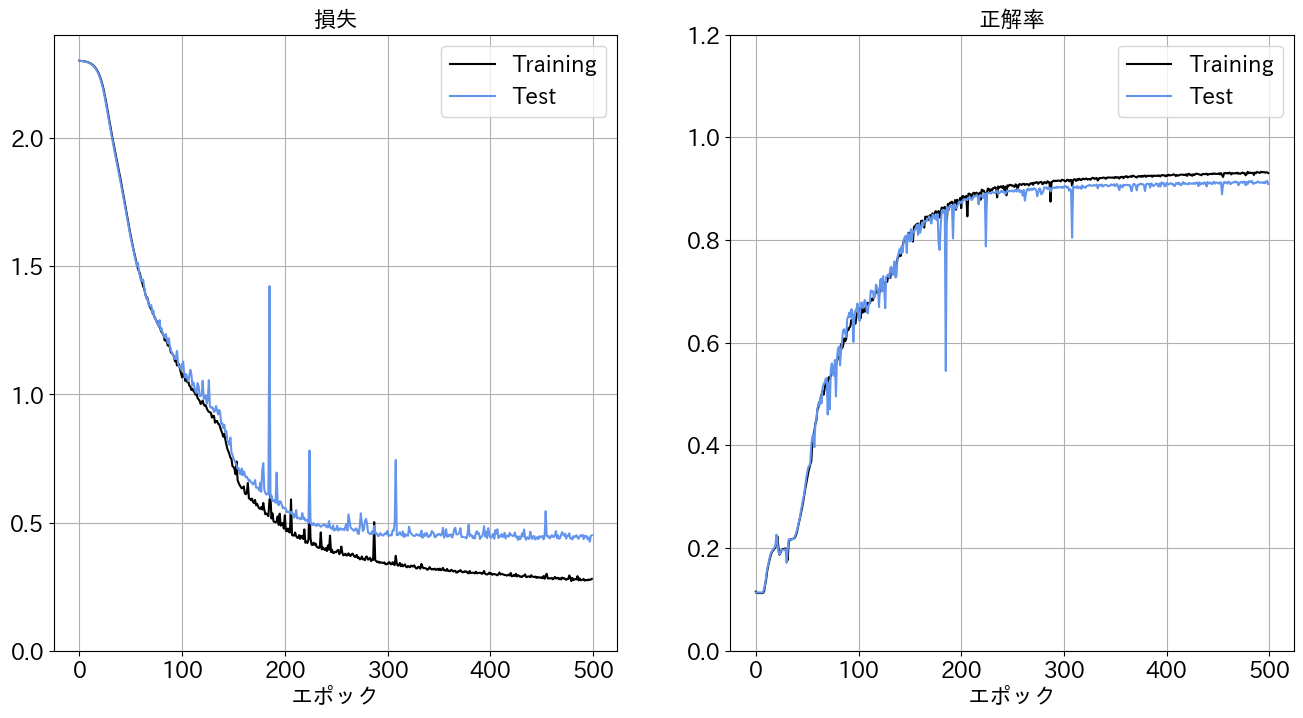

正解率
 0.91
精度
    0    1    2    3    4    5    6    7    8    9
 0.98 0.94 0.88 0.87 0.94 0.92 0.92 0.97 0.80 0.89
再現率
    0    1    2    3    4    5    6    7    8    9
 0.93 0.98 0.86 0.88 0.93 0.81 0.91 0.92 0.92 0.93


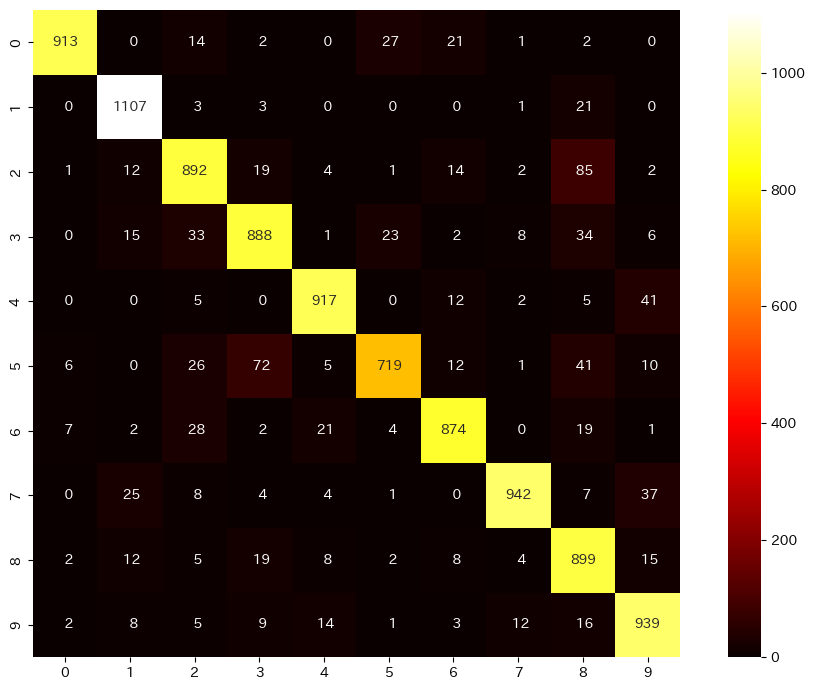

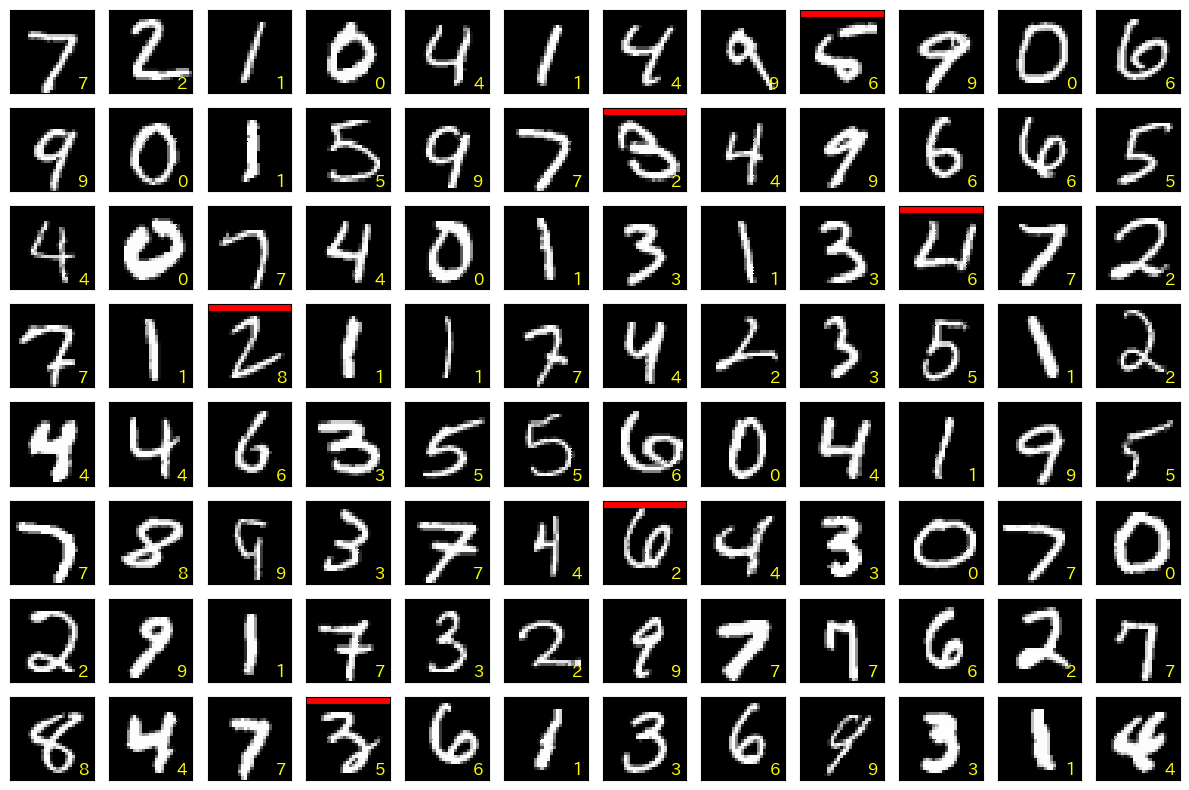

In [12]:
# 学習の履歴（損失と正解率の変化）を表示
show_history(history1)

# 学習したモデルを使い、テストデータのクラスラベルを予測
y_pred=model1.predict(x_test, verbose=0)

# 各データについて、最大の予測確率を持つクラスラベルを取得
y_pred=np.argmax(y_pred, axis=1)

# 正解（one-hotベクトル）をクラスラベルに戻す
y_true=np.argmax(y_test, axis=1)

# 混同行列、正解率、精度、再現率を評価
evalulate(x_test,y_true,y_pred)

# 予測結果の一部を可視化する
ids=range(96) # 可視化するデータの番号0から95

# データの番号0から95について、予測結果を可視化
show_prediction(x_test,y_true,y_pred,ids)

# 実習9.4：CIFAR-10データセット

170498071/170498071 [==============================] - 13s 0us/step
訓練データ
形状： (50000, 32, 32, 3)
画像枚数： 50000
画像の縦方向画素数： 32
画像の横方向画素数： 32
画像のチャネル数： 3
テストデータ
形状： (10000, 32, 32, 3)
画像枚数： 10000
画像の縦方向画素数： 32
画像の横方向画素数： 32
画像のチャネル数： 3


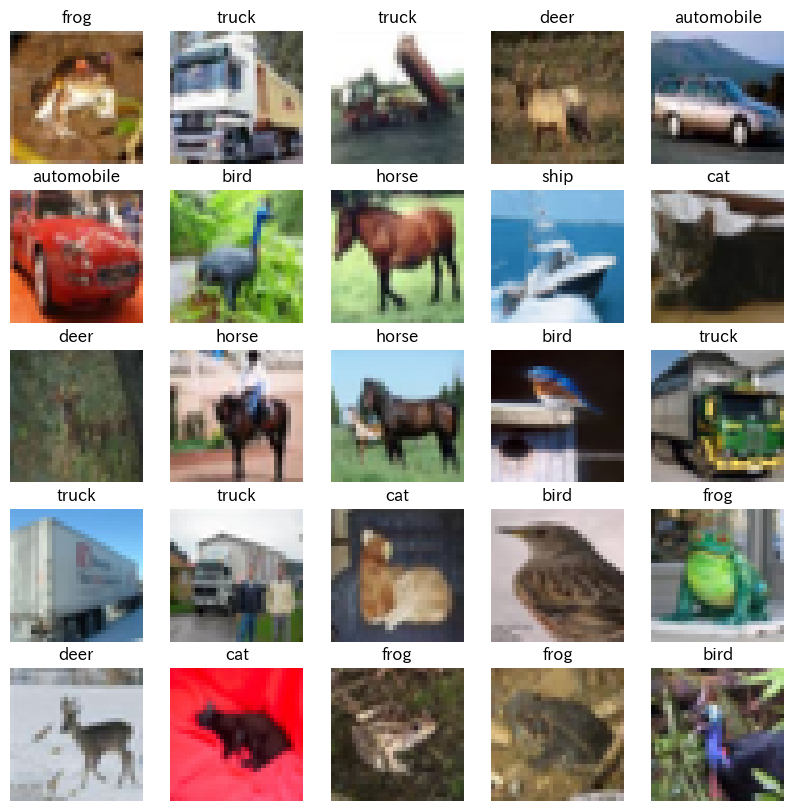

In [13]:
from tensorflow.keras.datasets import cifar10
import numpy as np

# ラベル名
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# この下にコードを記述する。
# CIFAR-10データセットをTensorflowのサイトからロード
# （訓練データ画像,　訓練データ・クラスラベル）,（テストデータ画像,　テストデータ・クラスラベル）
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

print('訓練データ')
print('形状：', x_train.shape) # (50000, 32, 32, 3) = (枚数, 高さ, 幅, チャネル数)
print('画像枚数：', len(x_train))
# 先頭の画像を取り出す。x_train[0]は3次元配列。形状(高さ,幅,チャネル数)をshapeプロパティで取得
ny,nx,nc=x_train[0].shape
print('画像の縦方向画素数：',ny)
print('画像の横方向画素数：',nx)
print('画像のチャネル数：',nc)

print('テストデータ')
print('形状：', x_test.shape)
print('画像枚数：', len(x_test))
ny,nx,nc=x_test[0].shape
print('画像の縦方向画素数：',ny)
print('画像の横方向画素数：',nx)
print('画像のチャネル数：',nc)

plt.figure(figsize=(10,10))
N=25 # 表示する画像枚数
for i in range(N):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i])
    label=labels[y_train[i,0]]
    plt.title(label)
    plt.axis('off')

plt.show()

# 実習9.5：CIFAR-10各クラスの画像枚数

In [14]:
# クラスラベルは0～9。
# その最大値は9。クラス数は10。
num_classes=np.max(y_train)+1
print('訓練データのクラス数：', num_classes)

for i in range(num_classes):
    # y_train==i: y_trainの各要素の値がクラスiに等しいか判定
    # 等しい（True）要素の個数をnp.sumで集計
    n=np.sum(y_train==i)
    print(i,n)

num_classes=np.max(y_test)+1
print('テストデータのクラス数：', num_classes)
for i in range(num_classes):
    n=np.sum(y_test==i)
    print(i,n)

訓練データのクラス数： 10
0 5000
1 5000
2 5000
3 5000
4 5000
5 5000
6 5000
7 5000
8 5000
9 5000
テストデータのクラス数： 10
0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


# 実習9.6：自然画像データセットCIFAR-10の教師データを準備

In [15]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

def load_cifar10():
    """手書きデータセットCIFAR-10を教師データとして用意する。
    Returns:
        x_train (ndarray): 訓練データの画像配列。形状(50000, 3072)
        y_train (ndarray): 訓練データのクラスラベル。one-hotベクトル化済み。形状(50000, 10)
        x_tes (ndarray): テストデータの画像配列。形状(10000, 3072)
        y_test (ndarray): テストデータのクラスラベル。one-hotベクトル化済み。形状(10000, 10)
        ny (int): 画像の縦方向画素数
        nx (int): 画像の横方向画素数
        nc (int): 画像のチャネル数
        num_classes (int): クラス数
    """
    (x_train,y_train),(x_test,y_test)=cifar10.load_data()
    ny,nx,nc=x_train[0].shape # 実習9.4

    # 訓練データ数 50000。1つの画像は 32 x 32 × 3 = 3072画素
    # 0から49999の各行には1個の画像が格納されている。
    # 全結合層へ入力するため、各画像をny * nx * nc個の成分を持つ1次元配列へ変換。
    x_train = x_train.reshape(-1, ny*nx*nc)
    x_train = x_train.astype('float32') # 要素値の型をfloat32へ変更
    # 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
    x_train=x_train/255

    # クラス数。0から9の数字なので10クラス
    num_classes=np.max(y_train)+1

    # クラスラベルをone-hotベクトル化
    y_train=to_categorical(y_train,num_classes)
    print('訓練データのクラスラベル形状：', y_train.shape)

    # テストデータの準備。テストデータ数 10000
    # 訓練データと同様に1次元配列へ変換
    x_test = x_test.reshape(-1, ny*nx*nc)
    x_test = x_test.astype('float32') # 要素値の型をfloat32へ変更
    # 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
    x_test=x_test/255

    # クラスラベルをone-hotベクトル化
    y_test=to_categorical(y_test,num_classes)
    print('テストデータのクラスラベル形状：', y_test.shape)

    return x_train, y_train, x_test, y_test, nx, ny, nc, num_classes

# 動作確認用
x_train, y_train, x_test, y_test, nx, ny, nc, num_classes = load_cifar10()

訓練データのクラスラベル形状： (50000, 10)
テストデータのクラスラベル形状： (10000, 10)


# 実習9.7：CIFAR-10分類用モデルの定義

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 教師データを再生成
x_train, y_train, x_test, y_test, nx, ny, nc, num_classes = load_cifar10()

# ネットワークのパラメータ（重みとバイアス）を初期化する際の乱数シードを固定
tf.random.set_seed(0)

n_hidden=10 # 中間層数

# ネットワークモデルを生成。層（レイヤー）の容器と考える。
model2=Sequential(name='FCN_CIFAR10')

# 最初の中間層を追加
model2.add(Dense(input_dim=ny*nx*nc, # 入力層のニューロン数(入力データの成分数)
                 units=10,           # 中間層1のニューロン数
                 activation='relu',  # 活性化関数ReLU
                 name='hidden1'))    # 中間層1の名前
# 2から9番目の中間層を追加
for i in range(2,n_hidden+1):
    model2.add(Dense(units=10,           # 中間層iのニューロン数
                     activation='relu',  # 活性化関数ReLU
                     name=f'hidden{i}')) # 中間層iの名前

# 出力層を追加
model2.add(Dense(units=10,             # 出力層のニューロン数
                 activation='softmax', # 活性化関数
                 name='output'))       # 出力層の名前

model2.compile(optimizer='SGD',                 # パラメータの最適化手法にAdamを指定
               loss='categorical_crossentropy', # 損失関数
               metrics=['accuracy'])            # 損失の他にモニターする指標として正解率を指定

# モデルの要約情報を表示
model2.summary()

訓練データのクラスラベル形状： (50000, 10)
テストデータのクラスラベル形状： (10000, 10)
Model: "FCN_CIFAR10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 10)                30730     
                                                                 
 hidden2 (Dense)             (None, 10)                110       
                                                                 
 hidden3 (Dense)             (None, 10)                110       
                                                                 
 hidden4 (Dense)             (None, 10)                110       
                                                                 
 hidden5 (Dense)             (None, 10)                110       
                                                                 
 hidden6 (Dense)             (None, 10)                110       
                                                                

# 実習9.8：CIFAR-10分類用モデルの学習

In [17]:
# 学習開始。終了後、学習の履歴がhistory2に代入される
history2=model2.fit(x_train, # 訓練データ：入力画像
                    y_train, # 訓練データ：クラスラベル
                    epochs=500, # エポック数
                    batch_size=1000, # バッチサイズ
                    shuffle=True,    # 学習時にデータの並びをシャッフル
                    validation_data=(x_test,y_test)) # 学習過程での汎化能力の推定のためテストデータを指定

Epoch 1/500
50/50 [==============================] - 2s 19ms/step - loss: 2.3025 - accuracy: 0.1045 - val_loss: 2.3025 - val_accuracy: 0.1043
Epoch 2/500
50/50 [==============================] - 1s 14ms/step - loss: 2.3025 - accuracy: 0.1026 - val_loss: 2.3025 - val_accuracy: 0.1042
Epoch 3/500
50/50 [==============================] - 1s 16ms/step - loss: 2.3025 - accuracy: 0.1064 - val_loss: 2.3025 - val_accuracy: 0.1123
Epoch 4/500
50/50 [==============================] - 1s 16ms/step - loss: 2.3024 - accuracy: 0.1157 - val_loss: 2.3024 - val_accuracy: 0.1034
Epoch 5/500
50/50 [==============================] - 1s 15ms/step - loss: 2.3024 - accuracy: 0.1065 - val_loss: 2.3024 - val_accuracy: 0.1216
Epoch 6/500
50/50 [==============================] - 1s 13ms/step - loss: 2.3024 - accuracy: 0.1199 - val_loss: 2.3024 - val_accuracy: 0.1192
Epoch 7/500
50/50 [==============================] - 1s 11ms/step - loss: 2.3023 - accuracy: 0.1118 - val_loss: 2.3024 - val_accuracy: 0.1212
Epoch 

# 実習9.9：CIFAR-10分類用モデルの学習の履歴と汎化能力の推定

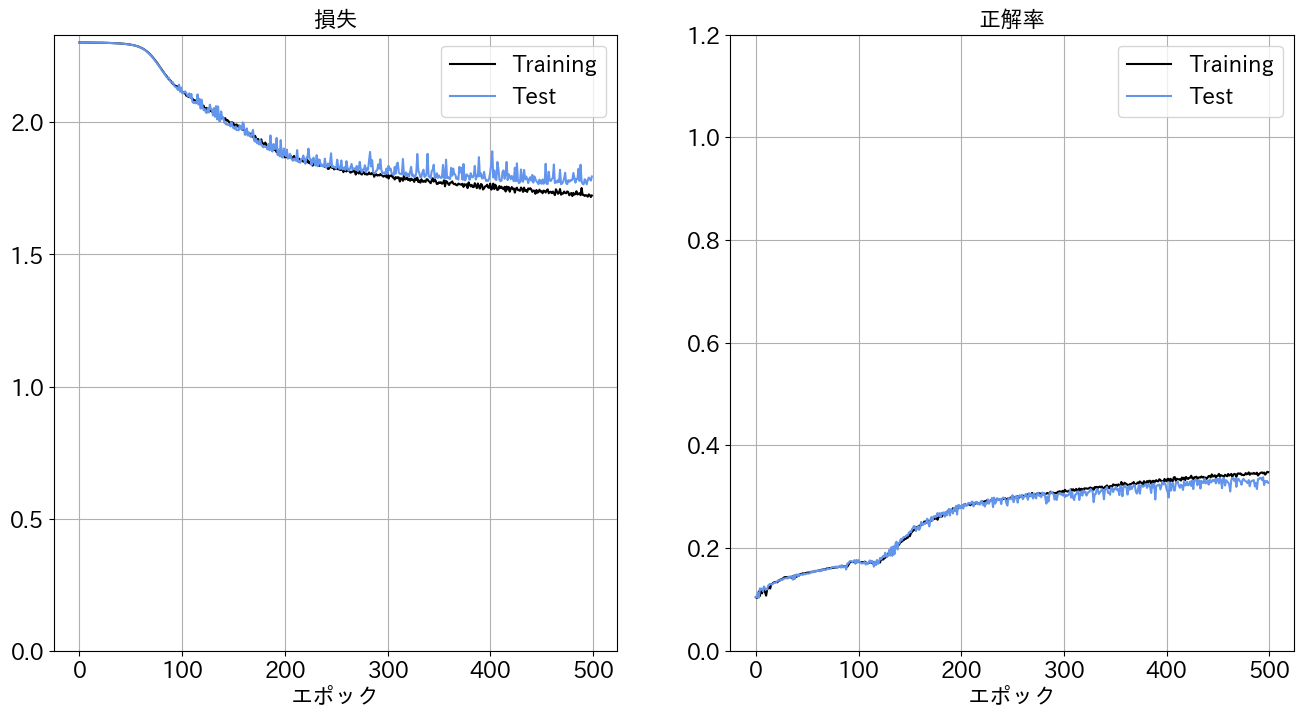

正解率
 0.33
精度
    0    1    2    3    4    5    6    7    8    9
 0.34 0.47 0.00 0.14 0.30 0.32 0.31 0.30 0.40 0.33
再現率
    0    1    2    3    4    5    6    7    8    9
 0.60 0.45 0.00 0.10 0.17 0.43 0.63 0.42 0.32 0.14


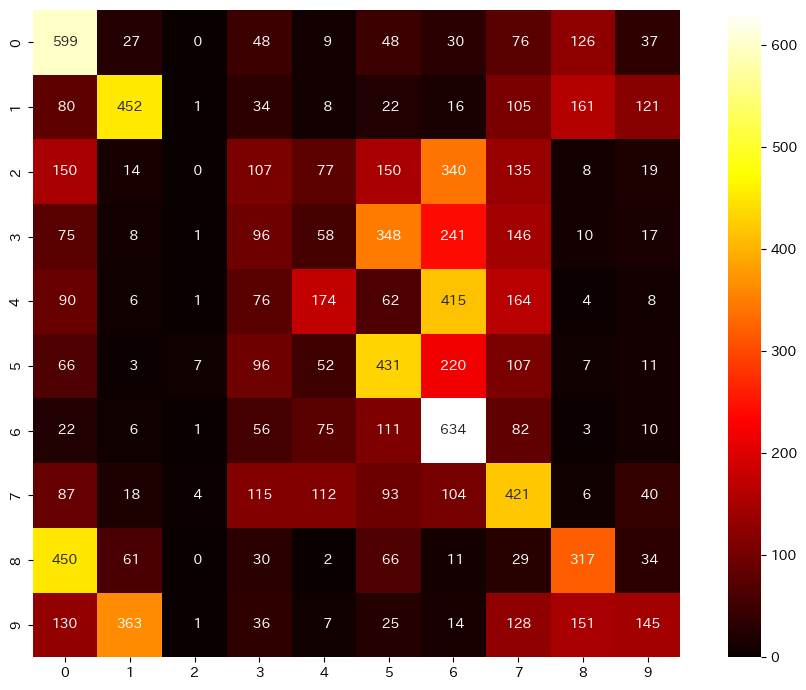

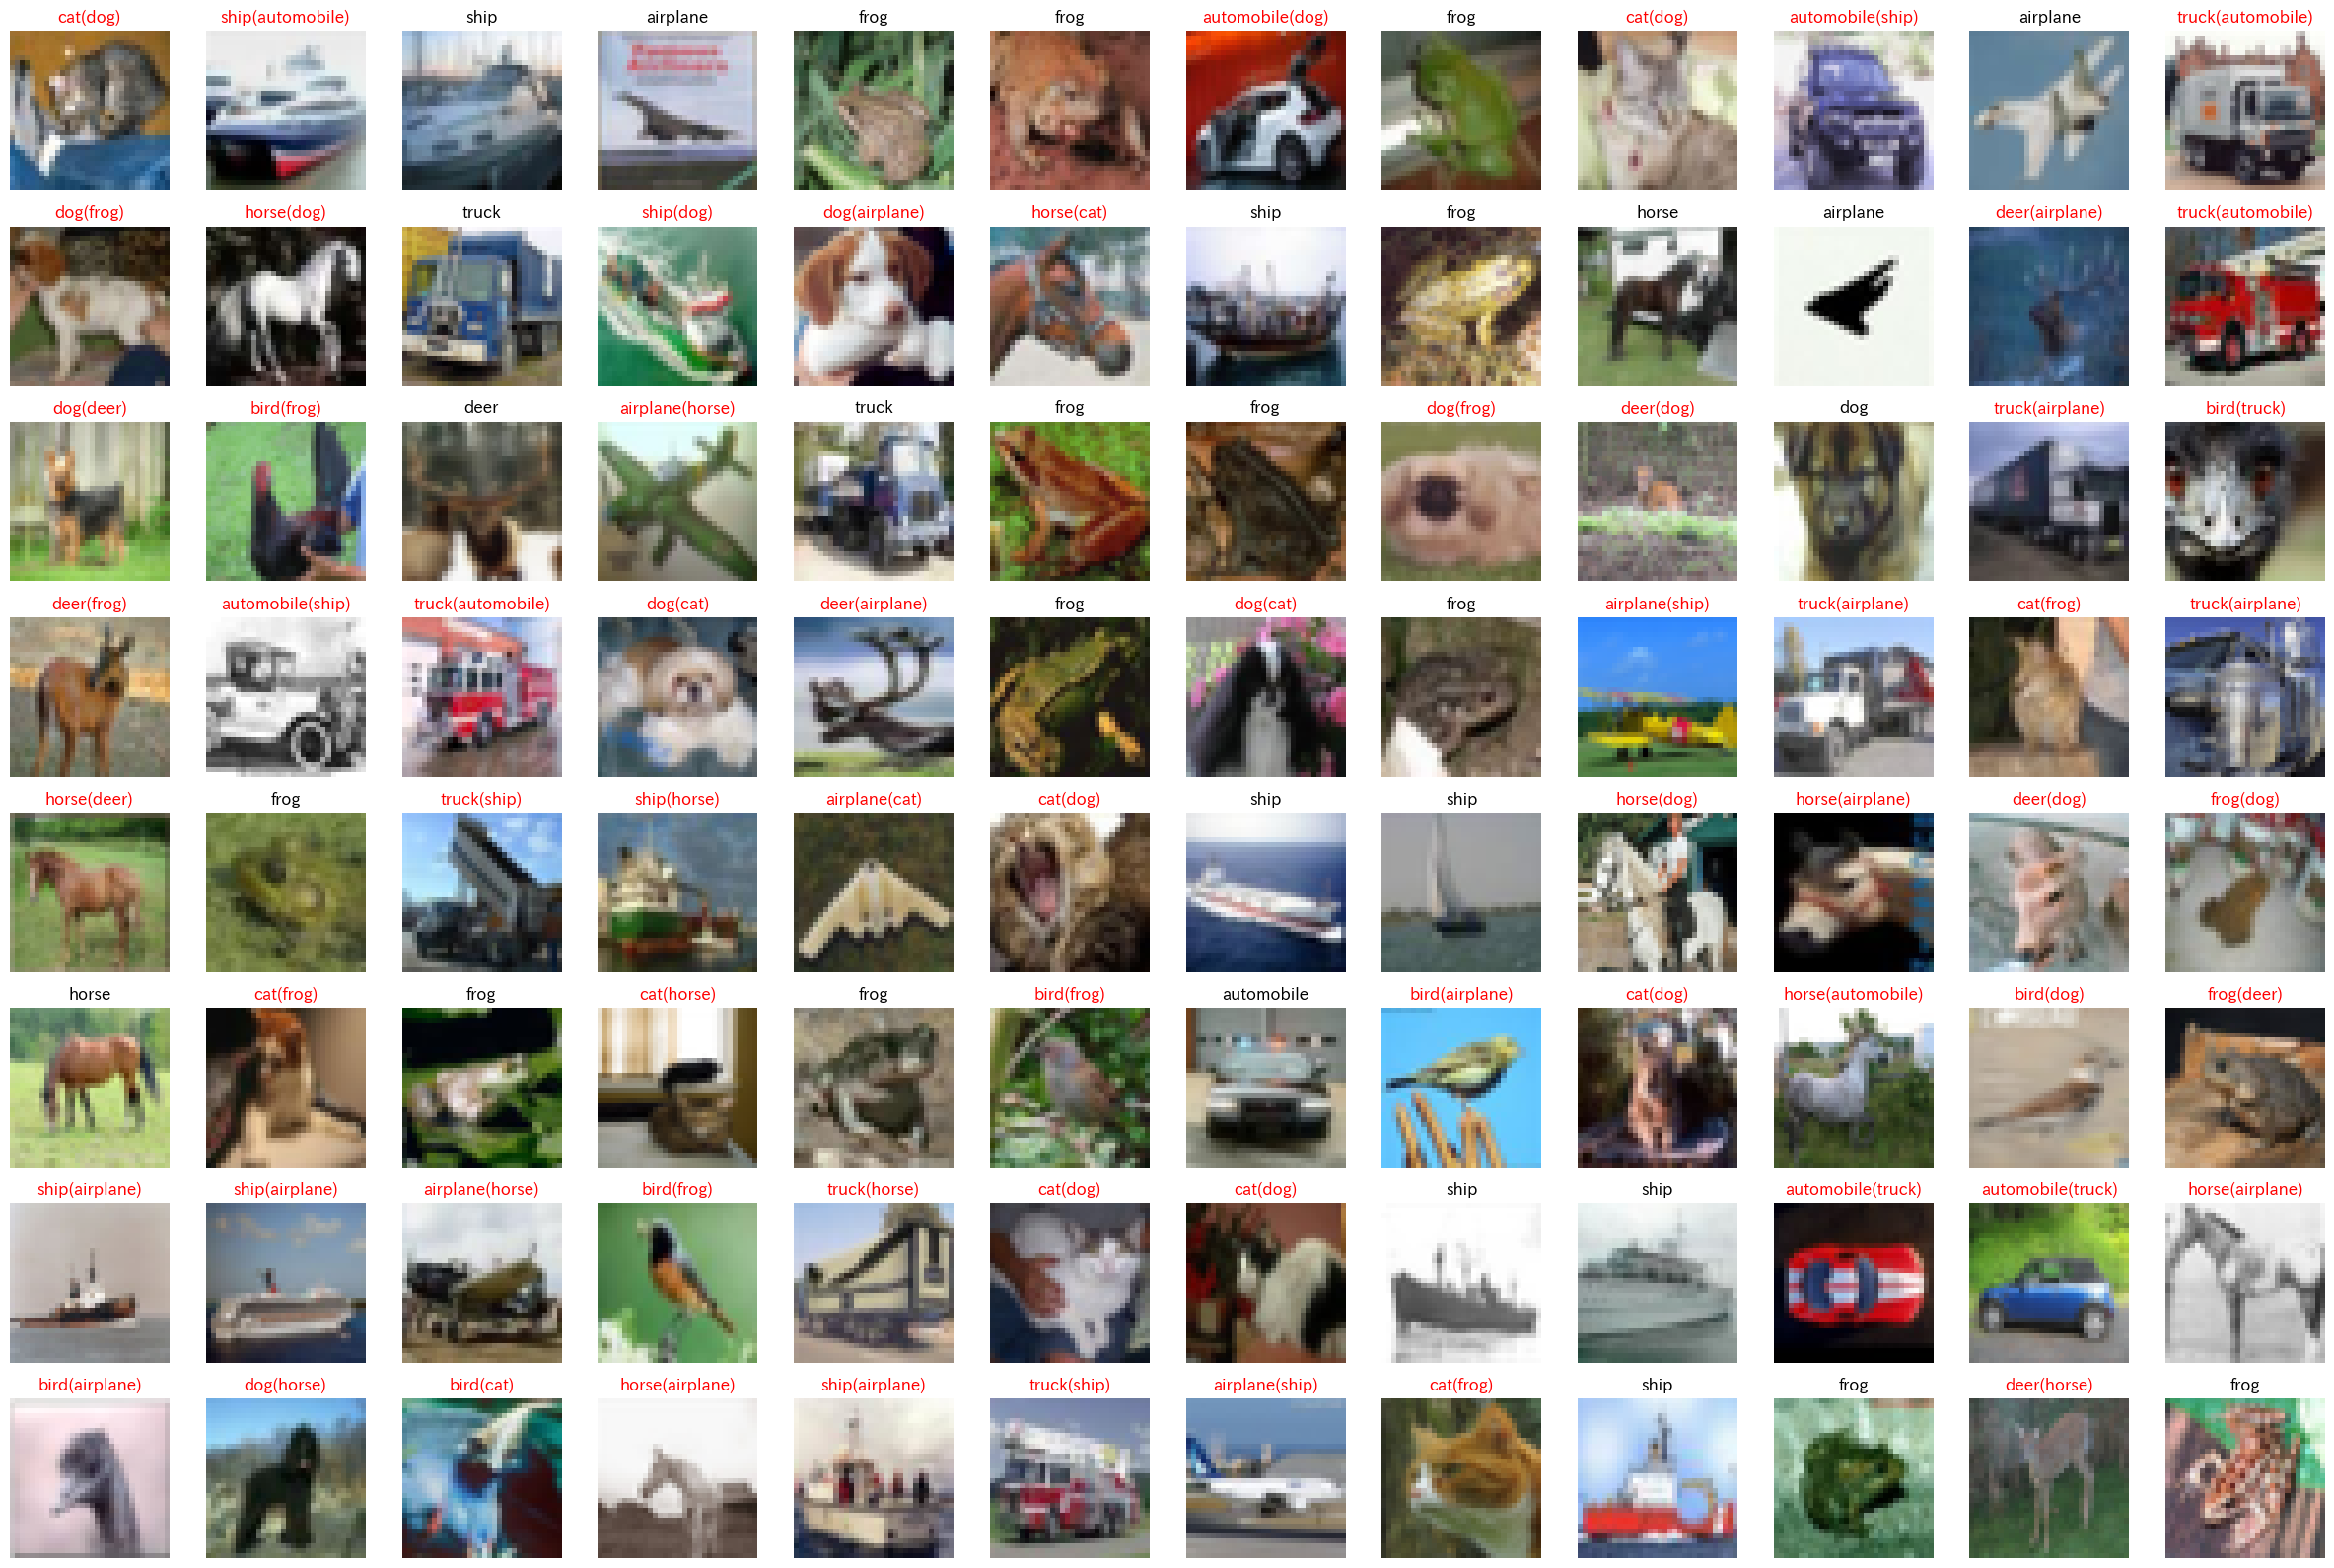

In [18]:
# 学習の履歴（損失と正解率の変化）を表示
show_history(history2)

# 学習したモデルを使い、テストデータのクラスラベルを予測
y_pred=model2.predict(x_test, verbose=0)

# 各データについて、最大の予測確率を持つクラスラベルを取得
y_pred=np.argmax(y_pred, axis=1)

# 正解（one-hotベクトル）をクラスラベルに戻す
y_true=np.argmax(y_test, axis=1)

# 混同行列、正解率、精度、再現率を評価
evalulate(x_test,y_true,y_pred)

# 予測結果の一部を可視化する
ids=range(96) # 可視化するデータの番号0から95

# データの番号0から95について、予測結果を可視化
show_prediction(x_test,y_true,y_pred,ids, dataset='cifar10',labels=labels)